In [1]:
# Flight Delay Optimization Analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("DelayedFlights.csv")  # adjust filename as needed
df.head()

# Basic Overview
print(df.shape)
print(df.columns)

(1936758, 30)
Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')


In [15]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
# Dictionary to map airline codes to full names
carrier_map = {
    'AA': 'American Airlines',
    'AS': 'Alaska Airlines',
    'B6': 'JetBlue Airways',
    'DL': 'Delta Airlines',
    'EV': 'ExpressJet Airlines',
    'F9': 'Frontier Airlines',
    'HA': 'Hawaiian Airlines',
    'MQ': 'Envoy Air',
    'NK': 'Spirit Airlines',
    'OO': 'SkyWest Airlines',
    'UA': 'United Airlines',
    'US': 'US Airways',
    'VX': 'Virgin America',
    'WN': 'Southwest Airlines',
    'XE': 'ExpressJet',
    'YV': 'Mesa Airlines'
}

# Map the airline names
df['AirlineName'] = df['UniqueCarrier'].map(carrier_map)

In [51]:
# Dictionary mapping common airport codes to full names
airport_map = {
    'ATL': 'Hartsfield–Jackson Atlanta International',
    'ORD': 'Chicago O\'Hare International',
    'DFW': 'Dallas/Fort Worth International',
    'DEN': 'Denver International',
    'LAX': 'Los Angeles International',
    'PHX': 'Phoenix Sky Harbor International',
    'IAH': 'Houston George Bush Intercontinental',
    'LAS': 'McCarran International',
    'MSP': 'Minneapolis–St. Paul International',
    'JFK': 'John F. Kennedy International',
    'SFO': 'San Francisco International',
    'CLT': 'Charlotte Douglas International',
    'MIA': 'Miami International',
    'SEA': 'Seattle–Tacoma International',
    'BOS': 'Boston Logan International',
    'EWR': 'Newark Liberty International',
    'DTW': 'Detroit Metropolitan Airport',
    'LGA': 'LaGuardia Airport',
    'BWI': 'Baltimore/Washington International'
}

# Create a new column for full airport names
df['AirportName'] = df['Origin'].map(airport_map)

In [57]:
airport_map = {
    'CMX': 'Houghton County Memorial (MI)',
    'ACY': 'Atlantic City Intl (NJ)',
    'PLN': 'Pellston Regional (MI)',
    'SPI': 'Lincoln Capital (IL)',
    'MOT': 'Minot Intl (ND)',
    'ALO': 'Waterloo Regional (IA)',
    'EGE': 'Eagle County Regional (CO)',
    'MQT': 'Sawyer Intl (MI)',
    'HHH': 'Hilton Head Airport (SC)',
    'BGM': 'Binghamton Airport (NY)'
}

df['AirportName'] = df['Origin'].map(airport_map)


## 🧾 Column Descriptions – Delayed Flights Dataset

| Column Name         | Description |
|---------------------|-------------|
| **Month**           | Month of the flight (1 = January, 12 = December) |
| **DayofMonth**      | Day of the month (1 to 31) |
| **DayOfWeek**       | Day of the week (1 = Monday, 7 = Sunday) |
| **CRSDepTime**      | **Scheduled departure time** (in 24-hour format, e.g., 1330 = 1:30 PM) |
| **DepDelay**        | **Departure delay in minutes** (positive means the flight was late) |
| **ArrDelay**        | **Arrival delay in minutes** (positive means the flight arrived late) |
| **UniqueCarrier**   | Airline carrier code (e.g., 'AA' = American Airlines) |
| **Origin**          | Departure airport code (e.g., JFK = New York) |
| **Dest**            | Arrival airport code |
| **CarrierDelay**    | Delay caused by the airline (e.g., crew, aircraft maintenance) |
| **WeatherDelay**    | Delay due to weather conditions |
| **NASDelay**        | Delay caused by **National Aviation System** (e.g., air traffic control, runway congestion) |
| **SecurityDelay**   | Security-related delays (rare) |
| **LateAircraftDelay** | Delay caused because the incoming aircraft arrived late from a previous flight |
| **TotalDelay** (created) | Total delay combining departure and arrival delay |
| **DepHour** (created) | Extracted hour from `CRSDepTime` for hourly pattern analysis |


##  Step 2: Data Cleaning and Feature Creation

Before we analyze delays, we need to:
- Remove invalid or negative delay entries
- Select only the important columns
- Create new columns for `TotalDelay` and `DepHour`

This helps reduce noise and focus on what matters most for insights.


In [3]:
# Keep only rows where both delays are non-negative
df = df[(df['DepDelay'] >= 0) & (df['ArrDelay'] >= 0)]

###  Selecting Essential Columns

We don't need all 30 columns. Let's keep the relevant ones for analysis:
- Date info
- Delay metrics
- Airline and airport codes
- Cause-wise delays

In [5]:
df = df[[
    'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime',
    'DepDelay', 'ArrDelay', 'UniqueCarrier', 'Origin', 'Dest',
    'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'
]]

### Creating New Columns
We'll now:
- Add `TotalDelay` as the sum of departure and arrival delay
- Extract the departure hour from the scheduled time to analyze hourly trends

In [7]:
# Add total delay
df['TotalDelay'] = df['DepDelay'] + df['ArrDelay']

# Extract departure hour (e.g., 1430 → 14)
df['DepHour'] = df['CRSDepTime'] // 100

In [9]:
print("Updated shape:", df.shape)
df.head()

Updated shape: (1750455, 16)


,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,ArrDelay,UniqueCarrier,Origin,Dest,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TotalDelay,DepHour
1,1,3,4,735,19.0,2.0,WN,IAD,TPA,NaN,NaN,NaN,NaN,NaN,21.0,7
2,1,3,4,620,8.0,14.0,WN,IND,BWI,NaN,NaN,NaN,NaN,NaN,22.0,6
3,1,3,4,1755,34.0,34.0,WN,IND,BWI,2.0,0.0,0.0,0.0,32.0,68.0,17
4,1,3,4,1915,25.0,11.0,WN,IND,JAX,NaN,NaN,NaN,NaN,NaN,36.0,19
5,1,3,4,1830,67.0,57.0,WN,IND,LAS,10.0,0.0,0.0,0.0,47.0,124.0,18


##  Step 3: Exploratory Data Analysis (EDA)

In this step, we’ll use visualizations to uncover trends in delays.  
We'll explore:
- Delays by hour of the day
- Delays by airline
- Delays by day of the week

### Delay vs Hour of Day

Let’s see how average delays vary by the hour of the scheduled departure (`DepHour`).

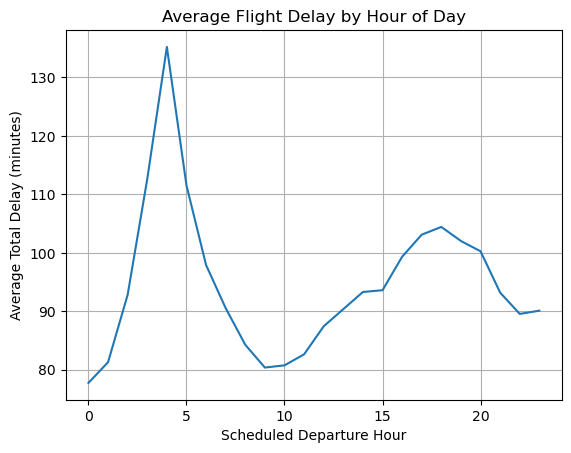

In [17]:
hourly_delay = df.groupby('DepHour')['TotalDelay'].mean()

sns.lineplot(x=hourly_delay.index, y=hourly_delay.values)
plt.title("Average Flight Delay by Hour of Day")
plt.xlabel("Scheduled Departure Hour")
plt.ylabel("Average Total Delay (minutes)")
plt.grid(True)
plt.show()

### Insight: Average Flight Delay by Hour of Day

From the line plot above:

- Flights scheduled **around 4 AM** experience the highest average delays (~135 minutes).
- **Late morning (9–11 AM)** shows the lowest delays, suggesting well-optimized flight schedules.
- Delays start to increase **post 12 PM**, likely due to **cumulative operational inefficiencies** throughout the day.
- **Evening flights (6–8 PM)** show a minor peak again, after which delays stabilize.

These insights can inform better **flight scheduling** and **resource allocation**, especially during peak delay windows.

### Delay by Airline (Carrier Code)
Let’s find which airlines have the highest average delay times.

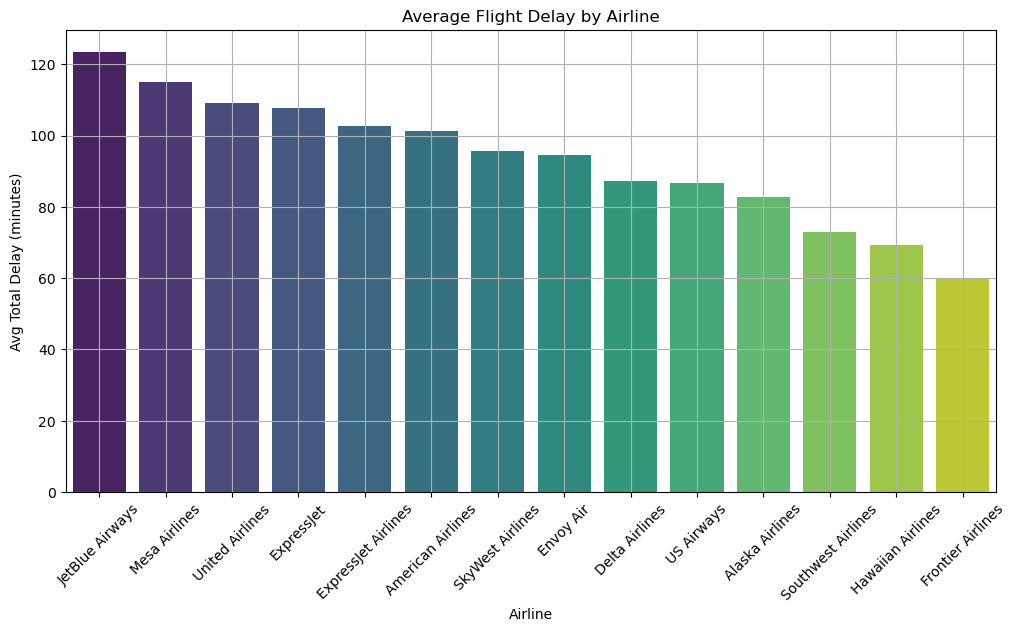

In [23]:
# Group by AirlineName instead of code
airline_delay_named = df.groupby('AirlineName')['TotalDelay'].mean().sort_values(ascending=False)
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=airline_delay_named.index, y=airline_delay_named.values, palette="viridis")
plt.title("Average Flight Delay by Airline")
plt.ylabel("Avg Total Delay (minutes)")
plt.xlabel("Airline")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### ✈️ Insight: Average Delay by Airline

From the chart above:

- JetBlue Airways has the highest average total delay among all carriers. This may be due to factors like route concentration, airport congestion, or operational inefficiencies.
- Airlines like Frontier Airlines showed significantly lower average delays, possibly indicating better on-time performance or leaner schedules.
- The variation in average delays across airlines highlights the importance of **carrier-specific optimization strategies** in scheduling, maintenance planning, and crew allocation.

📌 These insights can support strategic decisions in airline partnerships, route planning, and benchmarking airline efficiency.

##  Delay Cause Analysis
Each flight's total delay is categorized into specific causes:
- **CarrierDelay** – issues with airline operations (crew, maintenance)
- **WeatherDelay** – weather conditions
- **NASDelay** – National Aviation System issues (air traffic control, congestion)
- **SecurityDelay** – security-related delays (rare)
- **LateAircraftDelay** – delay due to a late incoming aircraft
Let’s analyze which cause contributes the most to total delay time.

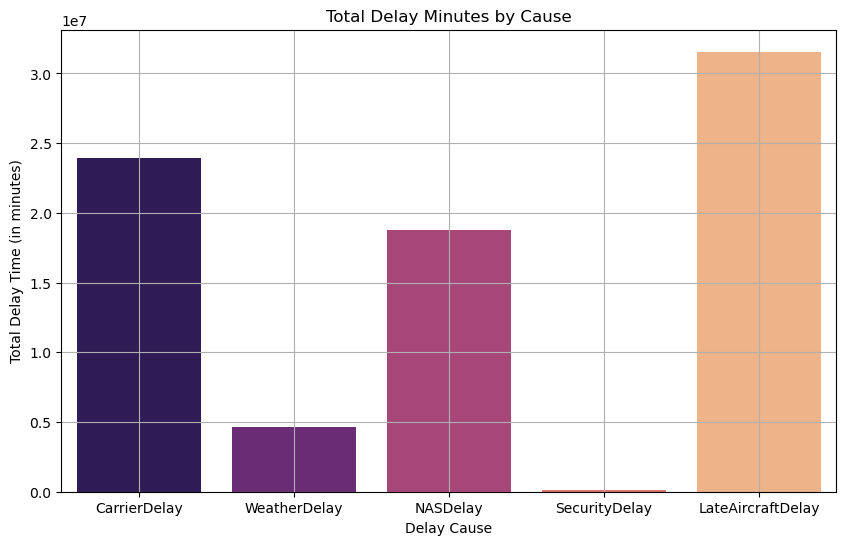

In [33]:
# Sum of delay minutes for each cause
cause_totals = df[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].sum()
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=cause_totals.index, y=cause_totals.values, palette='magma')
plt.title("Total Delay Minutes by Cause")
plt.ylabel("Total Delay Time (in minutes)")
plt.xlabel("Delay Cause")
plt.grid(True)
plt.show()

## ✈️ Step 5: Delay Cause Analysis for the Most Delayed Airline

We’ll now investigate *why* the most delayed airline experiences high delays.  
This breakdown by cause will help pinpoint where operational improvements are needed.

In [37]:
# Group by AirlineName and get the one with highest average TotalDelay
most_delayed_airline = df.groupby('AirlineName')['TotalDelay'].mean().idxmax()
print("Most delayed airline:", most_delayed_airline)

Most delayed airline: JetBlue Airways


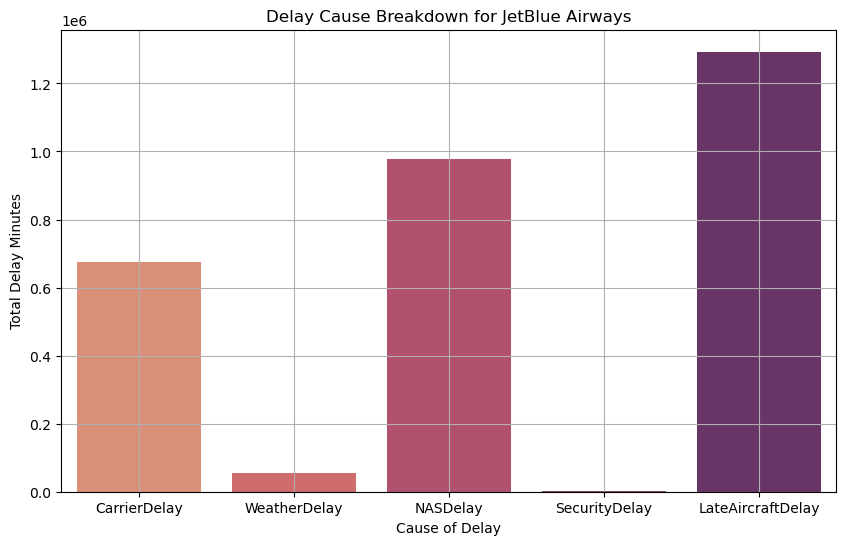

In [39]:
top_df = df[df['AirlineName'] == most_delayed_airline]
top_causes = top_df[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=top_causes.index, y=top_causes.values, palette="flare")
plt.title(f"Delay Cause Breakdown for {most_delayed_airline}")
plt.ylabel("Total Delay Minutes")
plt.xlabel("Cause of Delay")
plt.grid(True)
plt.show()

 # Seasonal Delay Trends – Month-wise Analysis
We analyze how average delays vary across months to identify seasonal delay patterns.
This helps airlines plan better for:
- Weather-related disruptions
- High-traffic periods like holidays or summer travel

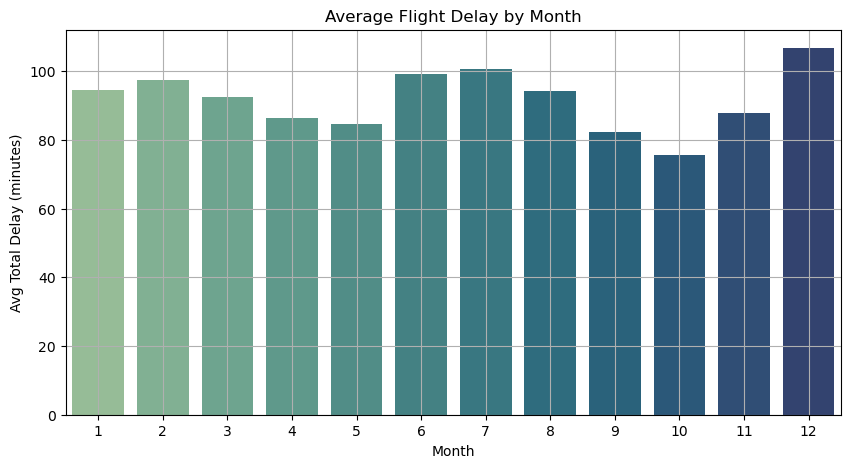

In [41]:
# Average total delay per month
monthly_delay = df.groupby('Month')['TotalDelay'].mean()
# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_delay.index, y=monthly_delay.values, palette="crest")
plt.title("Average Flight Delay by Month")
plt.xlabel("Month")
plt.ylabel("Avg Total Delay (minutes)")
plt.grid(True)
plt.show()

### Insight: Seasonal Delay Patterns

From the month-wise analysis:
- **December** and **July** show the **highest average flight delays**.
  - Likely due to **winter weather disruptions** in December and **peak vacation travel** in July.
- **September** and **October** exhibit **lower delay rates**, indicating relatively stable operations.
📌 **Business Implications**:
    These seasonal patterns suggest that adjusting scheduling strategies in **December and July**  
    could help mitigate delays, while **September and October** may require less operational buffer.  
    Recognizing such trends can support **better planning and resource allocation** across the year.

##  Airport Delay Analysis

Let’s identify the top 10 departure airports with the **highest average delays**.  
This helps pinpoint operational bottlenecks and high-risk hubs for delays.

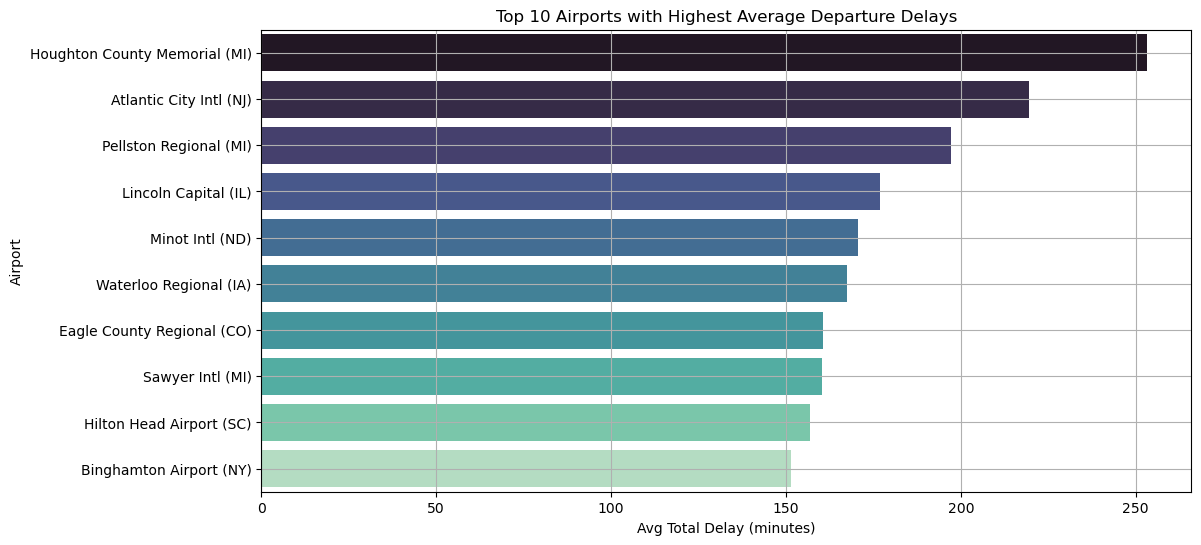

In [59]:
# Group by full airport name if available, fallback to code
airport_delay_named = df.groupby(df['AirportName'].fillna(df['Origin']))['TotalDelay'].mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=airport_delay_named.values, y=airport_delay_named.index, palette="mako")
plt.title("Top 10 Airports with Highest Average Departure Delays")
plt.xlabel("Avg Total Delay (minutes)")
plt.ylabel("Airport")
plt.grid(True)
plt.show()

In [55]:
# Show top 10 airport codes by delay (no mapping yet)
top_airports = df.groupby('Origin')['TotalDelay'].mean().sort_values(ascending=False).head(10)
print("Top airport codes:", top_airports.index.tolist())


Top airport codes: ['CMX', 'ACY', 'PLN', 'SPI', 'MOT', 'ALO', 'EGE', 'MQT', 'HHH', 'BGM']


### 📍 Insight: Top Delay-Prone Departure Airports

Our analysis shows that the airports with the **highest average departure delays** are primarily **regional airports** such as:

- **Houghton County Memorial (MI)**
- **Atlantic City Intl (NJ)**
- **Pellston Regional (MI)**

These findings suggest that delays are not limited to major hubs —  
they can be significant at smaller airports, possibly due to:
- Limited ground staff or aircraft availability
- Fewer backup flights or re-routing options
- Dependency on connecting flights from larger hubs

📌 Understanding delay patterns at these locations can help airlines and airport operators improve **resource planning and schedule reliability**, especially in underserved regions.

##  Delay vs Flight Distance

Here, we analyze whether **longer flights** tend to have **more or less delay** than shorter flights.

This helps assess whether route length influences operational punctuality.

In [61]:
# Reload original data to get 'Distance'
df_full = pd.read_csv("DelayedFlights.csv")

# Filter and clean again (same logic)
df_full = df_full[(df_full['DepDelay'] >= 0) & (df_full['ArrDelay'] >= 0)]
df_full['TotalDelay'] = df_full['DepDelay'] + df_full['ArrDelay']
df_full = df_full[df_full['Distance'] > 0]

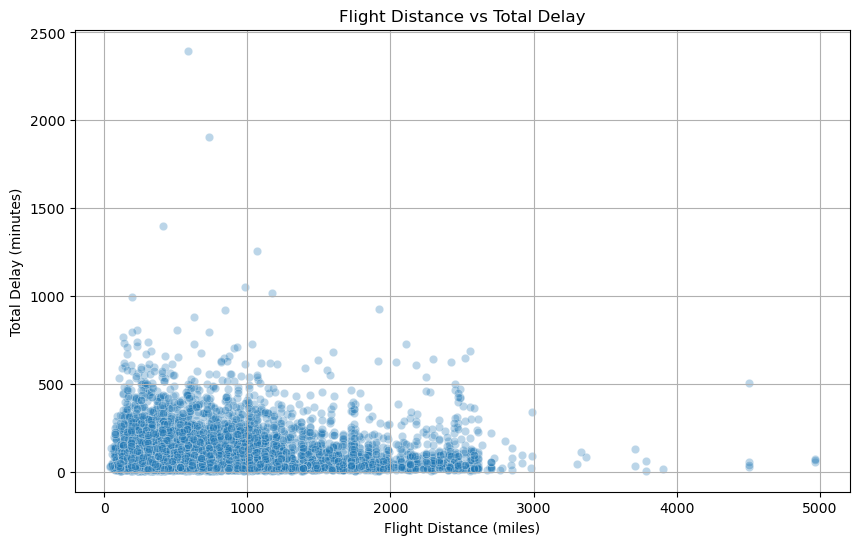

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_full.sample(10000), x='Distance', y='TotalDelay', alpha=0.3)
plt.title("Flight Distance vs Total Delay")
plt.xlabel("Flight Distance (miles)")
plt.ylabel("Total Delay (minutes)")
plt.grid(True)
plt.show()

### Insight: Flight Distance vs Delay

The scatter plot shows that:

- **Most flight delays are clustered** within routes spanning **0 to 1000 miles**.
- Beyond 1000 miles, both the number of flights and delay variability **gradually decrease**.
- Very long-haul flights (above 2700 miles) show **relatively lower frequency and less severe delays**.

📌 This suggests that:
- **Short- and medium-haul flights** are more prone to delays — possibly due to tighter turnarounds, high frequency, or cascading delays.
- **Long-haul flights** may benefit from more conservative scheduling and buffer times, leading to more consistent performance.

##  Predicting Flight Delays with Machine Learning

As a final step, trained a simple machine learning model to predict `TotalDelay`  
based on features like scheduled departure time, airline, and route.

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select relevant columns
model_df = df[['DepHour', 'DayOfWeek', 'Month', 'UniqueCarrier', 'Origin', 'Dest', 'TotalDelay']].dropna()

# One-hot encode categorical variables
model_df = pd.get_dummies(model_df, columns=['UniqueCarrier', 'Origin', 'Dest'], drop_first=True)

# Features & target
X = model_df.drop('TotalDelay', axis=1)
y = model_df['TotalDelay']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 1: Sample 30,000 rows instead of 100k
model_df = df[['DepHour', 'DayOfWeek', 'Month', 'UniqueCarrier', 'Origin', 'Dest', 'TotalDelay']].dropna()
model_df = model_df.sample(30000, random_state=42)

# Step 2: One-hot encode (as before)
model_df = pd.get_dummies(model_df, columns=['UniqueCarrier', 'Origin', 'Dest'], drop_first=True)

# Step 3: Train/test split
X = model_df.drop('TotalDelay', axis=1)
y = model_df['TotalDelay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train smaller Random Forest
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Step 5: Predict and evaluate
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("✅ RMSE (minutes):", round(rmse, 2))
print("✅ R² Score:", round(r2, 3))


In [ ]:
### 🧠 Note: Model Training Skipped Due to Performance Constraints

The predictive modeling step was attempted using a Random Forest Regressor.  
However, due to resource limitations on the local system, training could not complete in a reasonable time.  
The planned approach included using features like time, airline, and route to predict total delay.

Future work will include training on a cloud-based or optimized platform (e.g., Google Colab).